# **Step 1: Import Library**

In [59]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import SVD
from surprise import accuracy

# **Step 2: Load Dataset**

In [60]:
df = pd.read_csv("../data/Books_rating.csv.zip", compression="zip")

df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [ ]:
df.info()

print(f"Null rows:\n {df.isnull().sum()}")

print(f"Duplicated rows: {df.duplicated().sum()}")

print(f"Number of unique users: {df["User_id"].nunique()}")
print(f"Number of unique books: {df["Id"].nunique()}")
print(f"Number of unique ratings: {df["review/score"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Id                  object 
 1   Title               object 
 2   Price               float64
 3   User_id             object 
 4   profileName         object 
 5   review/helpfulness  object 
 6   review/score        float64
 7   review/time         int64  
 8   review/summary      object 
 9   review/text         object 
dtypes: float64(2), int64(1), object(7)
memory usage: 228.9+ MB
Null rows: Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
dtype: int64
Duplicated rows: 8774
Number of unique users: 1008972
Number of unique books: 221998
Number of unique r

# **Step 3: Data Preprocessing**

## ***Filtering***

In [62]:
df_filter = df[["Id", "User_id", "review/score"]].dropna().drop_duplicates()

df_filter.rename(columns={"User_id": "UserID", "Id": "BookID", "review/score": "Rating"}, inplace=True)

df_filter.head()

,BookID,UserID,Rating
0,1882931173,AVCGYZL8FQQTD,4.0
1,0826414346,A30TK6U7DNS82R,5.0
2,0826414346,A3UH4UZ4RSVO82,5.0
3,0826414346,A2MVUWT453QH61,4.0
4,0826414346,A22X4XUPKF66MR,4.0


In [63]:
df_filter.info()

print(df_filter.isnull().sum())

print(df_filter.describe())

print(f"Number of unique users: {df_filter["UserID"].nunique()}")
print(f"Number of unique books: {df_filter["BookID"].nunique()}")
print(f"Number of unique ratings: {df_filter["Rating"].nunique()}")

<class 'pandas.core.frame.DataFrame'>
Index: 2400673 entries, 0 to 2999998
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   BookID  object 
 1   UserID  object 
 2   Rating  float64
dtypes: float64(1), object(2)
memory usage: 73.3+ MB
BookID    0
UserID    0
Rating    0
dtype: int64
             Rating
count  2.400673e+06
mean   4.224403e+00
std    1.180885e+00
min    1.000000e+00
25%    4.000000e+00
50%    5.000000e+00
75%    5.000000e+00
max    5.000000e+00
Number of unique users: 1008972
Number of unique books: 216023
Number of unique ratings: 5


In [64]:
user_count = df_filter["UserID"].value_counts(ascending=True, normalize=True)
book_count = df_filter["BookID"].value_counts(ascending=True, normalize=True)
rating_count = df_filter["Rating"].value_counts(ascending=True, normalize=True)

print(user_count * 100)
print(book_count* 100)
print(rating_count * 100)

UserID
A13LUWG8W76IPM    0.000042
A3VEKUTR4QG4G     0.000042
AU0OWKMSXXZN7     0.000042
A1J7YW1M1AI5T4    0.000042
A2AP7LAXN8U31A    0.000042
                    ...   
A1K1JW1C5CUSUZ    0.056609
A1X8VZWTOG8IS6    0.073771
AHD101501WCN1     0.081977
AFVQZQ8PW0L       0.148625
A14OJS0VWMOSWO    0.230519
Name: proportion, Length: 1008972, dtype: float64
BookID
1882931173    0.000042
B0007DTRLS    0.000042
1559340223    0.000042
0898863856    0.000042
B0006AH2DM    0.000042
                ...   
B000NWQXBA    0.147667
B000PC54NG    0.147875
B000NWU3I4    0.148792
B000ILIJE0    0.149375
B000IEZE3G    0.152832
Name: proportion, Length: 216023, dtype: float64
Rating
2.0     4.943572
1.0     6.234877
3.0     8.782204
4.0    20.225079
5.0    59.814269
Name: proportion, dtype: float64


## ***Normalizing***

In [65]:
user_encoder = LabelEncoder()
book_encoder = LabelEncoder()

df_filter["UserID"] = user_encoder.fit_transform(df_filter["UserID"])
df_filter["BookID"] = book_encoder.fit_transform(df_filter["BookID"])

df_filter.head()

,BookID,UserID,Rating
0,127556,974366,4.0
1,72373,538933,5.0
2,72373,758571,5.0
3,72373,436243,4.0
4,72373,288505,4.0


In [81]:
probabilities = {
    1: 0.78,
    2: 1.0,
    3: 0.60,
    4: 0.24,
    5: 0.08
}

df_filter["keep"] = df_filter["Rating"].apply(lambda x: np.random.rand() < probabilities[x])

df_balanced = df_filter[df_filter["keep"]].drop(columns=["keep"])

print(df_balanced["Rating"].value_counts(normalize=True))

Rating
3.0    0.213619
2.0    0.200123
1.0    0.196957
4.0    0.196444
5.0    0.192857
Name: proportion, dtype: float64


## ***Visualizing***

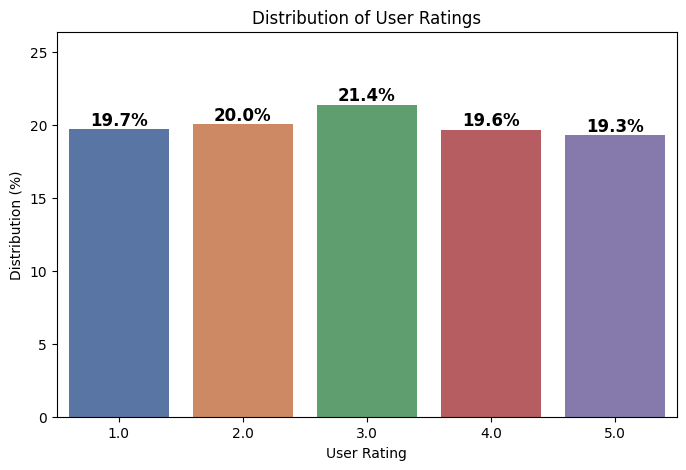

In [82]:
rating_counts = df_balanced["Rating"].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 5))
ax = sns.barplot(x=rating_counts.index, y=rating_counts.values, hue=rating_counts.index, palette="deep", legend=False)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.xlabel("User Rating")
plt.ylabel("Distribution (%)")
plt.title("Distribution of User Ratings")
plt.ylim(0, max(rating_counts.values) + 5)

plt.savefig("../images/user_rating_distribution.png", dpi=300, facecolor="white", bbox_inches="tight", transparent=True)

plt.show()

# **Step 4: Train Model**

In [93]:
min_reviews = 5
user_counts = df_balanced["UserID"].value_counts()
users_to_keep = user_counts[user_counts >= min_reviews].index
df_balanced = df_balanced[df_balanced["UserID"].isin(users_to_keep)]

print(df_balanced.info())
print(df_balanced.describe())
print(df_balanced.head())

print(f"Number of unique users: {df_balanced["UserID"].nunique()}")
print(f"Number of unique books: {df_balanced["BookID"].nunique()}")
print(f"Number of unique ratings: {df_balanced["Rating"].nunique()}")

print(df_balanced[(df_balanced["Rating"] < 1) | (df_balanced["Rating"] > 5)])
print(df_balanced[(df_balanced["UserID"] <= 0) | (df_balanced["BookID"] <= 0)])

<class 'pandas.core.frame.DataFrame'>
Index: 182381 entries, 3 to 2999994
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BookID      182381 non-null  int32  
 1   UserID      182381 non-null  int32  
 2   Rating      182381 non-null  float64
 3   user_index  182381 non-null  int64  
 4   book_index  182381 non-null  int64  
dtypes: float64(1), int32(2), int64(2)
memory usage: 7.0 MB
None
              BookID        UserID         Rating     user_index  \
count  182381.000000  1.823810e+05  182381.000000  182381.000000   
mean   131946.469117  5.034199e+05       2.921828   10681.304231   
std     65914.947694  2.918828e+05       1.238507    9173.732411   
min         1.000000  2.800000e+01       1.000000       0.000000   
25%     66275.000000  2.466760e+05       2.000000    3058.000000   
50%    148189.000000  5.003460e+05       3.000000    7952.000000   
75%    187075.000000  7.551740e+05       4.000000   16812.0

In [ ]:
print(df_balanced[df_balanced["BookID"] == 0])
print(f"Number of rows with BookID = 0: {df_balanced[df_balanced['BookID'] == 0].shape[0]}")

user_counts = df_balanced["UserID"].value_counts()
print(user_counts.describe())

Empty DataFrame
Columns: [BookID, UserID, Rating, user_index, book_index]
Index: []
Number of rows with BookID = 0: 0
count    16064.000000
mean        11.353399
std         16.229811
min          5.000000
25%          5.000000
50%          7.000000
75%         11.000000
max        698.000000
Name: count, dtype: float64


In [95]:
user_mapping = {user: idx for idx, user in enumerate(df_balanced["UserID"].unique())}
book_mapping = {book: idx for idx, book in enumerate(df_balanced["BookID"].unique())}

df_balanced["user_index"] = df_balanced["UserID"].map(user_mapping)
df_balanced["book_index"] = df_balanced["BookID"].map(book_mapping)

reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(df_balanced[["user_index", "book_index", "Rating"]], reader)

trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [70]:
from surprise.model_selection import GridSearchCV
from surprise import SVD

# Định nghĩa tham số cần tối ưu
param_grid = {
    "n_factors": [50, 100],
    "n_epochs": [20, 30],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.02, 0.05]
}

# Chạy Grid Search để tìm bộ tham số tốt nhất (bỏ verbose)
grid_search = GridSearchCV(SVD, param_grid, measures=["rmse"], cv=3)
grid_search.fit(data)

# Kết quả
print("Best RMSE:", grid_search.best_score["rmse"])
print("Best Params:", grid_search.best_params["rmse"])

Best RMSE: 1.2308965122682956
Best Params: {'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.02}


In [96]:
model = SVD(n_factors=100, random_state=42)

model.fit(trainset)

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
print(f"RMSE: {rmse:.4f}")

RMSE: 0.9858
RMSE: 0.9858
